# SPIN DISTRIBUTIONS FOR PROJECT ON TDEs
Andy Mummery, James Matthews, Sam Witte

Had lunch with Andy Mummery and James Matthews on 8/2/24 and chatted about Andy's project trying to measure SMBH spin with TDEs. Theory suggests this is possible if SMBH spin is large (see Mummery & Balbus 2020: https://arxiv.org/pdf/2006.00803.pdf). Seems to tie in with Chris Done's method of measuring black hole spin using X-ray/UV SED ratios: https://arxiv.org/pdf/1306.4786.pdf

Andy just needs a theoretical spin distribution, split by mass, to draw from. We can get that from Horizon-AGN data. 

In [176]:
from astropy.table import Table, Column
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import erfinv
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp
from scipy.stats import pearsonr
from scipy.stats import rv_histogram
from scipy.stats import binned_statistic_2d as bs2d
from astropy import units as un
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from tqdm import trange

plt.rc('figure', facecolor='none', edgecolor='none', autolayout=True)
plt.rc('path', simplify=True)
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('axes', labelsize='large', facecolor='none', ec='k', linewidth=0.7)#, color_cycle = ['k', 'r', 'g', 'b', 'c', 'm', 'y'])
plt.rc('xtick', labelsize='medium', c='k', direction='in', top='on')
plt.rc('ytick', labelsize='medium', c='k', direction='in', right='on')
plt.rc('xtick.minor', visible='True')
plt.rc('ytick.minor', visible='True')
plt.rc('lines', markersize=4, linewidth=1, markeredgewidth=1)
plt.rc('legend', numpoints=1, frameon=False, handletextpad=0.3, scatterpoints=1, handlelength=2, handleheight=0.1)
plt.rc('savefig', facecolor='none', edgecolor='none')

params =   {'font.size' : 20,
            'xtick.major.size': 12,
            'ytick.major.size': 12,
            'xtick.minor.size': 6,
            'ytick.minor.size': 6,
            }
plt.rcParams.update(params)

import warnings
warnings.filterwarnings('ignore')

In [200]:
simdata = Table.read('spindata_z_00761.fits')

First let's look at the overall spin distribution of the Horizon-AGN sample. Output 00761 corresponds to redshift z=0.05560733369933746


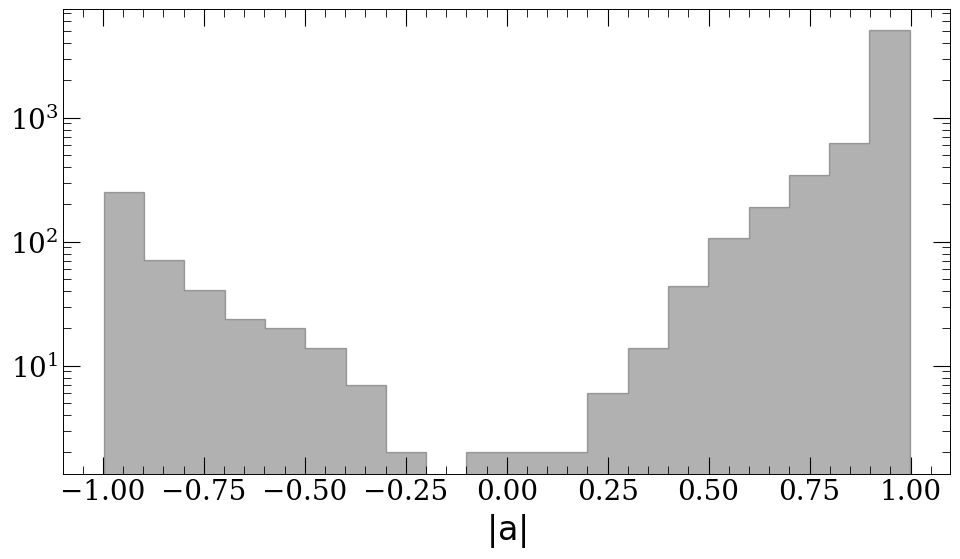

In [201]:
plt.figure(figsize=(10,6))
ax1 = plt.subplot(111)
ax1.hist(simdata['spinmag'], alpha=0.3, color='k', bins=20, histtype='stepfilled', ec='k')
ax1.set_xlabel(r'$|\rm{a}|$')
ax1.set_yscale('log')

Now let's look at how spin is related to stellar mass of the SMBH   

Text(0, 0.5, '$\\log_{10}[M_{\\rm{BH}}/\\rm{M}_{\\odot}]$')

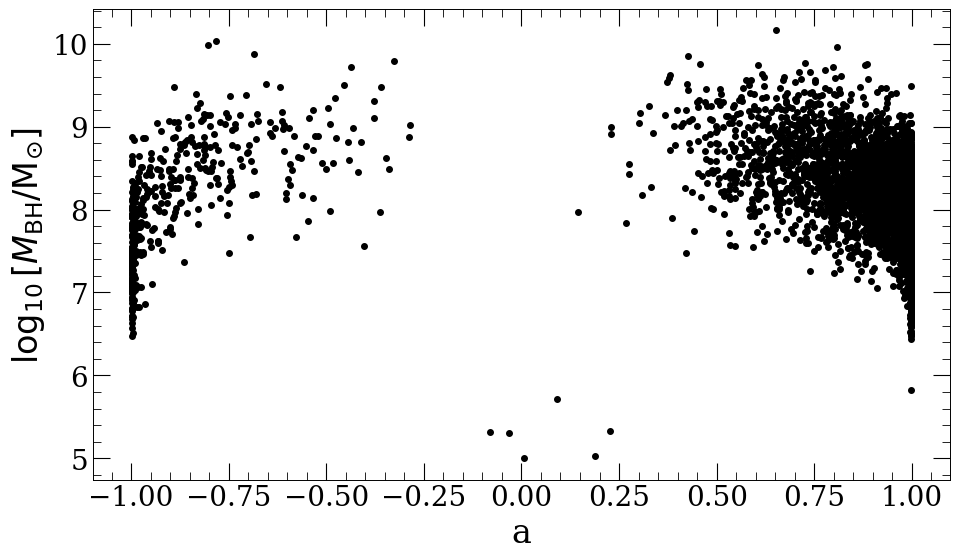

In [202]:
plt.figure(figsize=(10,6))
plt.scatter(simdata['spinmag'], np.log10(simdata['mbh']), color='k')
plt.xlabel(r'a')
plt.ylabel(r'$\log_{10}[M_{\rm{BH}}/\rm{M}_{\odot}]$')

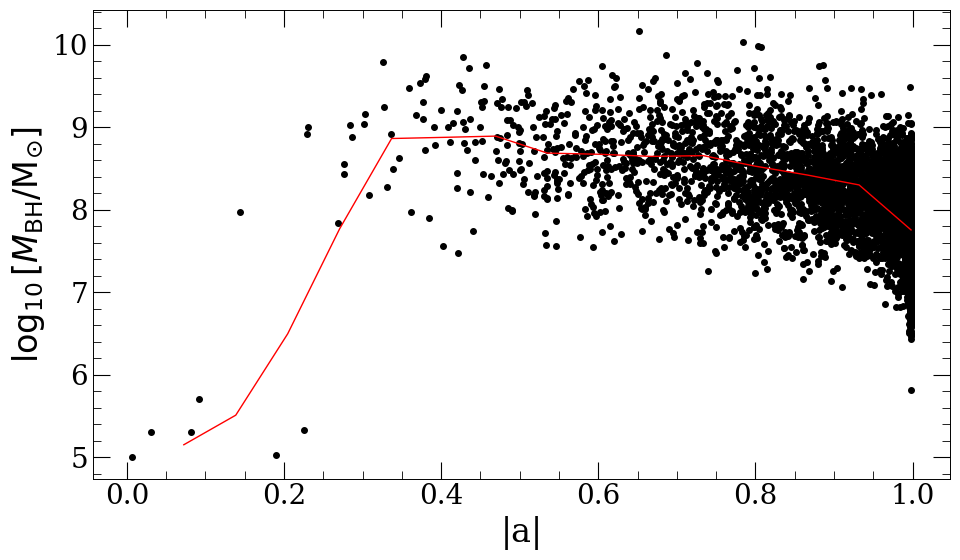

In [203]:
from scipy.stats import binned_statistic as bs
stat, bin_edges, binnum = bs(x=np.abs(simdata['spinmag']), values=np.log10(simdata['mbh']), statistic=np.nanmean, bins=15)
plt.figure(figsize=(10,6))
plt.scatter(np.abs(simdata['spinmag']), np.log10(simdata['mbh']), color='k')
plt.plot(bin_edges[1:], stat, color='r')
plt.xlabel(r'|a|')
plt.ylabel(r'$\log_{10}[M_{\rm{BH}}/\rm{M}_{\odot}]$')
plt.savefig('horizon-AGN_abs_spin_vs_MBH')

Alright, we need to bin this data in SMBH mass first, so let's define the bin edges in terms of the percentiles of the simulated sample.   

In [204]:
pc_edges = [0,20,40,60,80,90,95,97.5,99,100]
def_bin_edges = np.nanpercentile(np.log10(simdata['mbh']), [0,20,40,60,80,90,95,97.5,99,100])
stat, bin_edges, binnum = bs(x=np.log10(simdata['mbh']),values="None", statistic="count", bins=def_bin_edges)


Andy & Sam are interested in the high spin and high mass SMBHS specifically. So let's define some unequal sized bins in spin to start.

100%|██████████| 8/8 [00:00<00:00, 72.81it/s]


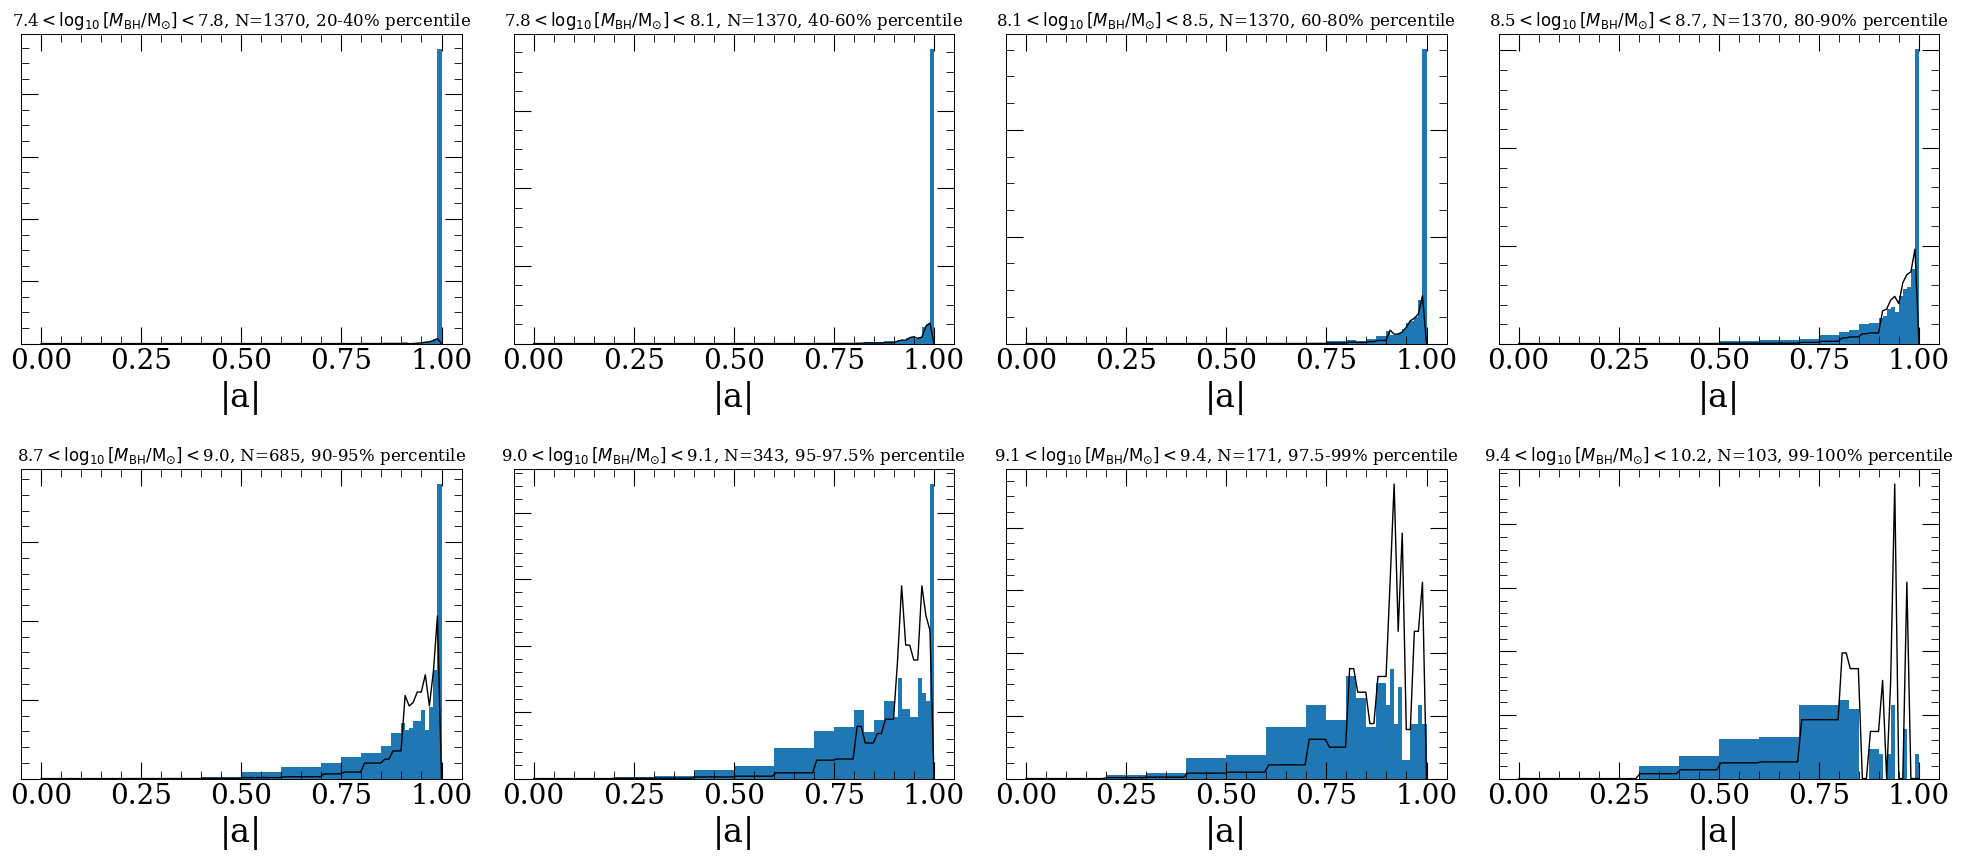

In [209]:
finebins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.825, 0.85, 0.875, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
X = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(20,9))
gs = fig.add_gridspec(2, 4)
j = 0
for n in trange(1,len(def_bin_edges)-1):
    ax = fig.add_subplot(gs[j])
    idx = np.where(binnum==n)[0]
    values, hbins, patches = ax.hist(np.abs(simdata[idx]['spinmag']), density=True, bins=finebins)
    hist_dist = rv_histogram([values, hbins], density=False)
    ax.plot(X, hist_dist.pdf(X), c='k')
    ax.set_xlabel(r'|a|')
    ax.set_title("{:.1f}".format(bin_edges[n])+r'$< \log_{10}[M_{\rm{BH}}/\rm{M}_{\odot}] < $'+"{:.1f}".format(bin_edges[n+1])+", N="+str(len(idx))+', '+str(pc_edges[n])+'-'+str(pc_edges[n+1])+'% percentile', fontsize=12)
    ax.set_yticklabels([])
    j+=1
fig.subplots_adjust()
fig.savefig('range_spins_mass_bins_horizon-AGN.png')
    

The problem is that the scipy rv_histogram PDF doesn't work well with uneven bin sizes. If Sam and Andy are going to use a different method to draw from the distribution this might not be an issue. But I reckon logarithmic bins in (1-|a|) would be a better idea to deal with the peaks at high spin and also allow the use of rv_histogram PDFs. 

 25%|██▌       | 2/8 [00:00<00:00,  6.47it/s]

100%|██████████| 8/8 [00:00<00:00,  8.05it/s]


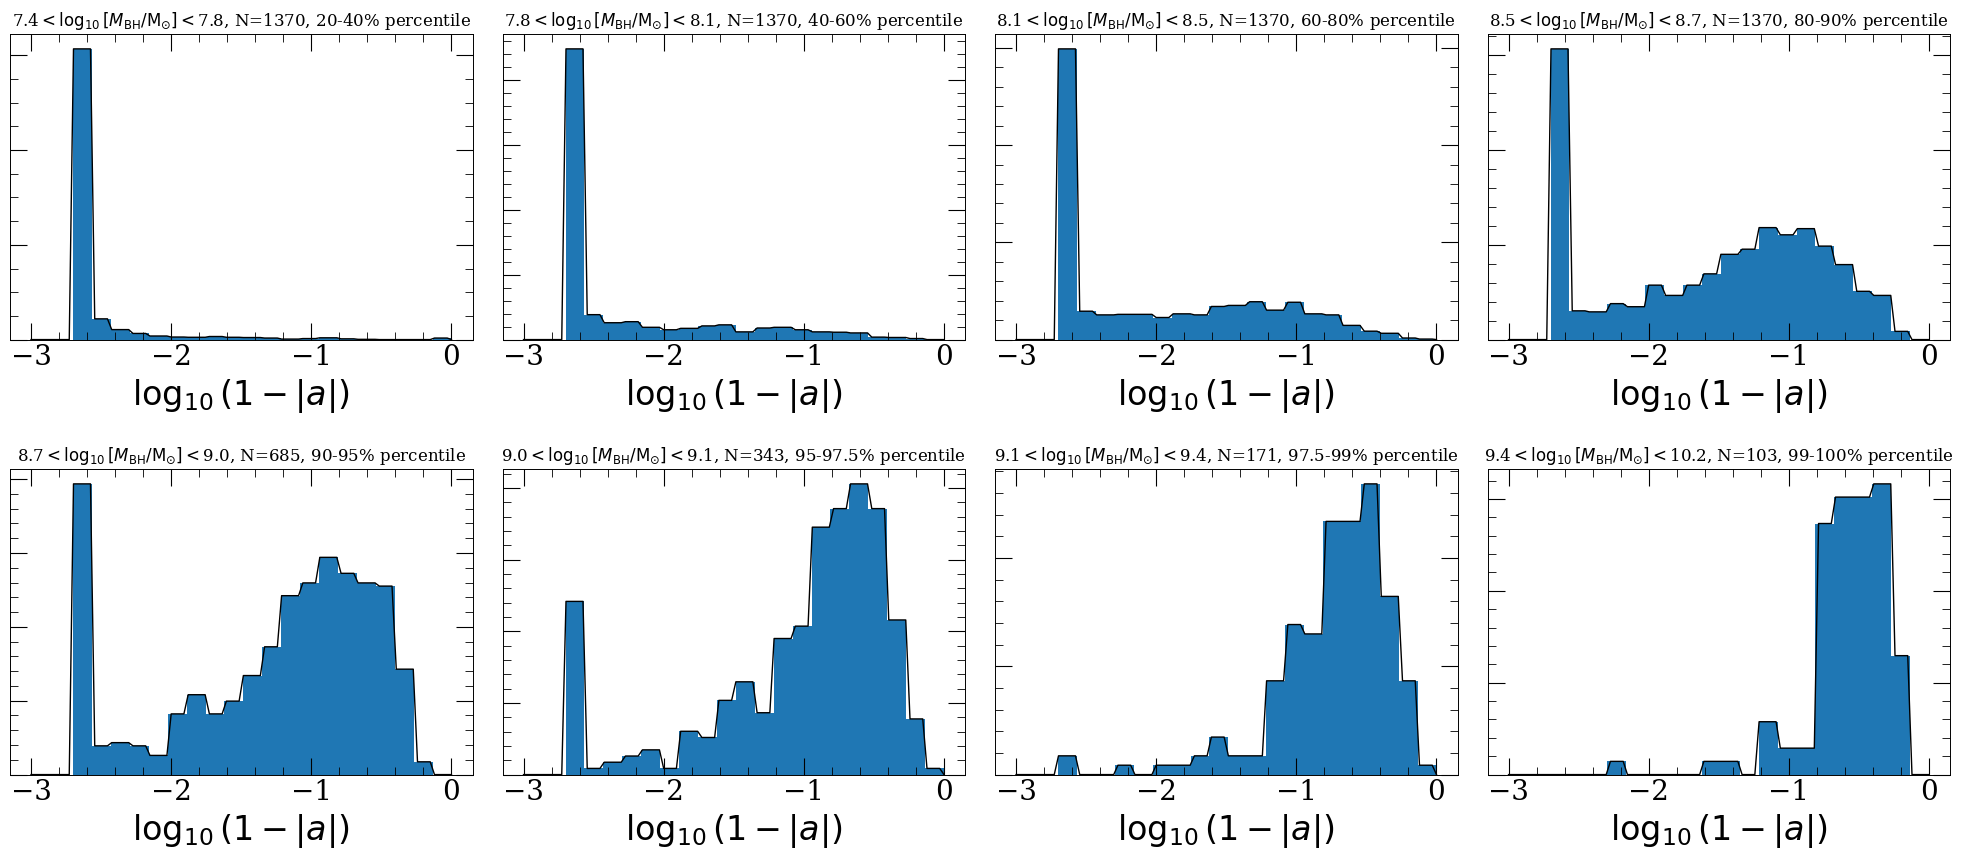

In [212]:
finebins = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.825, 0.85, 0.875, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999])
X = np.linspace(-3, 0, 100)
fig = plt.figure(figsize=(20,9))
gs = fig.add_gridspec(2, 4)
j = 0
for n in trange(1,len(def_bin_edges)-1):
    ax = fig.add_subplot(gs[j])
    idx = np.where(binnum==n)[0]
    values, hbins, patches = ax.hist(np.log10(1-np.abs(simdata[idx]['spinmag'])), density=True, bins=20, range=(-2.7,0))
    hist_dist = rv_histogram([values, hbins], density=False)
    ax.plot(X, hist_dist.pdf(X), c='k')
    #ax.set_yscale('log')
    ax.set_xlabel(r'$\log_{10}(1-|a|)$')
    ax.set_title("{:.1f}".format(bin_edges[n])+r'$< \log_{10}[M_{\rm{BH}}/\rm{M}_{\odot}] < $'+"{:.1f}".format(bin_edges[n+1])+", N="+str(len(idx))+', '+str(pc_edges[n])+'-'+str(pc_edges[n+1])+'% percentile', fontsize=12)
    ax.set_yticklabels([])
    j+=1
fig.subplots_adjust()
fig.savefig('range_spins_mass_log_bins_horizon-AGN.png')
    